In [138]:
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pingouin as pg
import seaborn as sns

In [139]:
data_path = "data_cleaned_feature_31.csv"
data = pd.read_csv(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds'],
      dtype='object')


(650048, 31)

In [140]:
data = data.drop(['video_trending_country'],axis=1).drop_duplicates()
data = data.drop_duplicates(subset=['video_id'])
data.shape

(23334, 30)

In [110]:
def time_to_seconds(time_str):
    days, time_part = time_str.split(" days ")
    days = int(days)
    h, m, s = map(int, time_part.split(":"))
    total_seconds = days * 86400 + h * 3600 + m * 60 + s
    return total_seconds

data['time_to_trend_difference_seconds'] = data['time_difference'].apply(time_to_seconds)
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']
data['is_weekend'] = pd.to_datetime(data['video_published_at']).dt.weekday >= 5

In [111]:
data['is_trending'] = data['time_difference'].apply(
    lambda x: 1 if int(x.split(" ")[0]) <= 1 else 0 
)
data.is_trending.value_counts() ## checking how fast videos are trending

is_trending
1    16498
0     6836
Name: count, dtype: int64

In [112]:
# do split (" ") and take the first element

data["time_difference_days"] = data["time_difference"].apply(lambda x: int(x.split(" ")[0]))
data["time_difference_days"]

0         0
1         0
2         2
3        -1
4         2
         ..
649469    0
649477    1
649487    0
649530    0
649532    0
Name: time_difference_days, Length: 23334, dtype: int64

In [113]:
# use data['video_published_at'] to make a column if morning, afternoon, evening, night
data['video_published_at'] = pd.to_datetime(data['video_published_at'])
data['published_hour'] = data['video_published_at'].dt.hour
data['published_morning'] = data['published_hour'].between(6, 12)
data['published_afternoon'] = data['published_hour'].between(12, 18)
data['published_evening'] = data['published_hour'].between(18, 24)
data['published_night'] = data['published_hour'].between(0, 6)

In [114]:
data['channel_published_at'] = pd.to_datetime(data['channel_published_at'], errors='coerce').dt.tz_localize(None)
data['video_published_at'] = pd.to_datetime(data['video_published_at'], errors='coerce').dt.tz_localize(None)
data['channel_video_channel_publish_difference'] = (data['video_published_at'] - data['channel_published_at']).dt.days
data['channel_video_channel_publish_difference']
data['channel_video_channel_publish_difference'] = data['channel_video_channel_publish_difference'].fillna(data['channel_video_channel_publish_difference'].mean()) # di ko na alam kung tama to

In [115]:
data.shape

(23334, 42)

In [116]:
data['is_trending'].value_counts()

is_trending
1    16498
0     6836
Name: count, dtype: int64

In [117]:
data['is_weekend'].value_counts()

is_weekend
False    16493
True      6841
Name: count, dtype: int64

In [118]:
data.is_trending.value_counts()

is_trending
1    16498
0     6836
Name: count, dtype: int64

In [119]:
majority_class = data[data['is_trending'] == 1]
minority_class = data[data['is_trending'] == 0]
# shape
print(majority_class.shape, minority_class.shape)


(16498, 42) (6836, 42)


In [120]:
from sklearn.utils import resample


minority_upsampled = resample(minority_class, 
                              replace=True,     
                              n_samples=int(round(len(majority_class) * 0.5, -2)),  
                              random_state=42)  

data = pd.concat([majority_class, minority_upsampled])
data.is_trending.value_counts()

is_trending
1    16498
0     8200
Name: count, dtype: int64

In [121]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_country', 'channel_have_hidden_subscribers',
    'published_morning', 'published_afternoon', 'published_evening', 'published_night'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference'
]

In [122]:
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
#X_text = data[embedded_text_columns]?
y = data['is_trending']

In [123]:
# from sklearn.ensemble import IsolationForest
# isolation_forest = IsolationForest(contamination=0.10, random_state=42) 
# outliers = isolation_forest.fit_predict(X_numerical)

# data_cleaned = data[outliers != -1]
# data_cleaned.shape

In [124]:
import numpy as np
#X = np.hstack((X_numerical, X_categorical))
X = pd.concat((X_numerical, X_categorical),axis=1)
X.shape

(24698, 14)

In [125]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from feature_engine.pipeline import Pipeline

pipeline = Pipeline([
    ("drop_constant_features", DropConstantFeatures(tol=0.98)),
    ("drop_duplicate_features", DropDuplicateFeatures()),
    ("drop_correlated_features", DropCorrelatedFeatures(method='pearson', threshold=0.85))
])

X_final = pipeline.fit_transform(X)

In [126]:
# check difference of columns between X and X_final
set(X.columns) - set(X_final.columns)

{'channel_have_hidden_subscribers', 'video_definition', 'video_dimension'}

In [127]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

In [128]:
categorical_features = [
    'video_category_id', 'is_weekend' ,'video_licensed_content',
    'channel_country', 
    'published_morning', 'published_afternoon', 'published_evening', 'published_night'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference'
]

In [129]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

In [130]:
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder

encoder = DecisionTreeEncoder(random_state=42, regression=False)
X_train_encode = encoder.fit_transform(X_train_categorical, y_train)
X_test_encode = encoder.transform(X_test_categorical)

c:\Users\Administrator\anaconda3\envs\ptcnn\Lib\site-packages\feature_engine\encoding\base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) channel_country.
  warnings.warn(


In [131]:
# from feature_engine.transformation import LogTransformer

# log_transformer = LogTransformer(variables=numerical_features)

# X_train_log = log_transformer.fit_transform(X_train_numerical)
# X_test_log = log_transformer.transform(X_test_numerical) # di naman gumana hahahaha

In [132]:
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_combined, X_test_combined)

In [133]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numerical)
X_test_scaled = scaler.transform(X_test_numerical)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

In [134]:
X_train = np.hstack((X_train_encode, X_train_scaled))
X_test = np.hstack((X_test_encode, X_test_scaled))

In [135]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model Accuracy: 0.8423751686909582
[[1791  679]
 [ 489 4451]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.75      2470
           1       0.87      0.90      0.88      4940

    accuracy                           0.84      7410
   macro avg       0.83      0.81      0.82      7410
weighted avg       0.84      0.84      0.84      7410



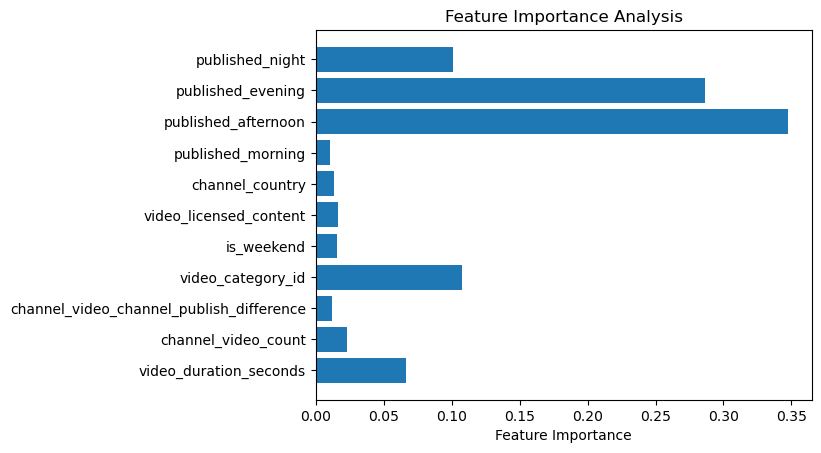

In [137]:
import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
feature_names = list(X_train_numerical.columns) + list(X_train_categorical.columns)
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()